In [8]:
#preflight to check for installed packages, install if not present
source("https://bioconductor.org/biocLite.R")
biocLite("GenomeInfoDbData")
pkg_str <- c("edgeR", "qvalue", "DESeq", "baySeq","stringr")
for(i in seq_along(pkg_str)) {
    suppressPackageStartupMessages(library(pkg_str[i],character.only = T))
}

Bioconductor version 3.6 (BiocInstaller 1.28.0), ?biocLite for help
BioC_mirror: https://bioconductor.org
Using Bioconductor 3.6 (BiocInstaller 1.28.0), R 3.4.1 (2017-06-30).
Installing package(s) ‘GenomeInfoDbData’
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Old packages: 'annotate', 'backports', 'biomaRt', 'bit64', 'checkmate',
  'crayon', 'curl', 'data.table', 'DBI', 'digest', 'edgeR', 'ensembldb',
  'fastcluster', 'foreign', 'Formula', 'GenomicAlignments', 'GenomicFeatures',
  'GenomicRanges', 'Gviz', 'Hmisc', 'htmlTable', 'htmlwidgets', 'httpuv',
  'httr', 'jsonlite', 'knitr', 'lambda.r', 'lattice', 'lazyeval', 'limma',
  'MASS', 'Matrix', 'openssl', 'pbdZMQ', 'R6', 'Rcpp', 'RCurl', 'repr',
  'reshape2', 'rlang', 'rpart', 'rtracklayer', 'scales', 'shiny', 'stringi',
  'SummarizedExperiment', 'survival', 'tibble', 'VariantAnnotation', 'viridis',
  'XML', 'yaml'


In [9]:
input_filename = "combined.counts.txt"

c1 <- 2
g1 <- 3
c2 <- 5
g2 <- 3

#Apply default settings
min_row_count <- 3
pvalue <- 0.05
dispersion <- 0.4
tagwise_flag <- T
qvalue_flag <- T
sampsize <- 1000

In [50]:
#Load Data
rt_filename = "SraRunTable.txt"

rt = read.table(rt_filename,header=T,sep='\t')
rt[order(rt$genetic_modification,rt$Run,),c(6:10)]

,Run,SRA_Sample,Sample_Name,genetic_modification,Assay_Type
13,ERR899421,ERS739413,E-MTAB-3599:Sample 7,EZH2 was transduced for shRNA knockdown of endogenous EZH2 and stably expresses murine wild-type EZH2,RNA-Seq
11,ERR899425,ERS739411,E-MTAB-3599:Sample 8,EZH2 was transduced for shRNA knockdown of endogenous EZH2 and stably expresses murine wild-type EZH2,RNA-Seq
9,ERR899435,ERS739409,E-MTAB-3599:Sample 9,EZH2 was transduced for shRNA knockdown of endogenous EZH2 and stably expresses murine wild-type EZH2,RNA-Seq
8,ERR899422,ERS739408,E-MTAB-3599:Sample 15,H689A was transduced for shRNA knockdown of endogenous EZH2 and stably expresses murine enzymatically inactive EZH2,RNA-Seq
4,ERR899431,ERS739404,E-MTAB-3599:Sample 13,H689A was transduced for shRNA knockdown of endogenous EZH2 and stably expresses murine enzymatically inactive EZH2,RNA-Seq
3,ERR899432,ERS739403,E-MTAB-3599:Sample 14,H689A was transduced for shRNA knockdown of endogenous EZH2 and stably expresses murine enzymatically inactive EZH2,RNA-Seq
6,ERR899427,ERS739406,E-MTAB-3599:Sample 6,MIG was transduced for shRNA knockdown of endogenous EZH2,RNA-Seq
1,ERR899429,ERS739401,E-MTAB-3599:Sample 4,MIG was transduced for shRNA knockdown of endogenous EZH2,RNA-Seq
10,ERR899433,ERS739410,E-MTAB-3599:Sample 5,MIG was transduced for shRNA knockdown of endogenous EZH2,RNA-Seq
12,ERR899423,ERS739412,E-MTAB-3599:Sample 12,NLS was transduced for shRNA knockdown of endogenous EZH2 and stably expresses murine cytosolic EZH2,RNA-Seq


In [11]:
#Load Data
df = read.table(input_filename,header=T,sep='\t')

df = df[c(-2:-6)]
df = df[ rowSums(df[-1])!=0, ] 
a <- names(df)
a <- gsub("..star_output.", "", a)
a <- gsub("Aligned.out.bam", "", a)
names(df) <- a

head(df)


cat("Use the following columns names for selection in next cell\n")
cat(paste('"',paste(colnames(df),collapse='","'),'"',sep=""))

,Geneid,ERR899421,ERR899422,ERR899423,ERR899424,ERR899425,ERR899426,ERR899427,ERR899428,ERR899429,ERR899430,ERR899431,ERR899432,ERR899433,ERR899434,ERR899435,ERR899436,ERR899437,ERR899438
10,ENSMUSG00000103147,2,2,1,0,1,1,0,0,0,1,0,2,0,1,0,0,0,0
17,ENSMUSG00000102948,0,0,0,1,4,0,0,1,0,1,0,0,3,0,2,0,1,0
18,ENSMUSG00000025900,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
22,ENSMUSG00000102269,26,32,34,37,27,42,24,35,24,31,22,25,33,28,29,29,25,22
26,ENSMUSG00000102735,0,0,0,0,4,0,1,0,1,3,0,3,3,1,1,2,2,0
27,ENSMUSG00000098104,84,63,79,231,83,131,98,145,175,78,145,77,102,60,97,109,178,113


Use the following columns names for selection in next cell
"Geneid","ERR899421","ERR899422","ERR899423","ERR899424","ERR899425","ERR899426","ERR899427","ERR899428","ERR899429","ERR899430","ERR899431","ERR899432","ERR899433","ERR899434","ERR899435","ERR899436","ERR899437","ERR899438"

In [13]:
selected_columns_a = c("ERR899434","ERR899438","ERR899437")
selected_columns_b = c("ERR899422","ERR899431","ERR899432")
fac <- c("ut",'ut','ut',
         'ia','ia','ia')

selected_columns = c("Geneid",selected_columns_a,selected_columns_b)

head(df[selected_columns])

# Specify appropriate factor labes for the sample names above.
# Treatments must have the same name

cat("Factors for data table are:", paste(fac,collapse=","))

,Geneid,ERR899434,ERR899438,ERR899437,ERR899422,ERR899431,ERR899432
10,ENSMUSG00000103147,1,0,0,2,0,2
17,ENSMUSG00000102948,0,0,1,0,0,0
18,ENSMUSG00000025900,0,0,0,0,0,0
22,ENSMUSG00000102269,28,22,25,32,22,25
26,ENSMUSG00000102735,1,0,2,0,0,3
27,ENSMUSG00000098104,60,113,178,63,145,77


Factors for data table are: ut,ut,ut,ia,ia,ia

In [14]:
# Read Data
now <- format(Sys.time(), "%m-%d-%Y_%H-%M-%S")
analysis.time <- paste("MultiSpec Analysis Started on", format(Sys.time(), "%m-%d-%Y"), "at", format(Sys.time(), "%H:%M:%S"), sep=" ")
cat("\n\n")
cat(analysis.time, "\n")
cat("\nRunning MultiSpec - A multi-DE Analysis\n")
cat(paste("Significant Threshold =", pvalue, "\n"))
cat("\n")
cat(paste("Performing MultiSpec Analysis on:\n", "Data File:", input_filename,"\n"))

datafile.counts <- df[, c(selected_columns_a,selected_columns_b)]
rownames(datafile.counts) = df[, 1]



MultiSpec Analysis Started on 01-22-2018 at 09:11:03 

Running MultiSpec - A multi-DE Analysis
Significant Threshold = 0.05 

Performing MultiSpec Analysis on:
 Data File: combined.counts.txt 


In [15]:
#filter data such that a row must have = specified min counts
cat(paste("\nFiltering Genes IDs\n"))
cat(paste("  Genes before filtering = ",nrow(datafile.counts),"\n"))

min_counts = 20
min_row_min_count = 3
        
df = df[rowSums(df[,-1] >= min_counts) >= min_row_min_count,]
#filter by min counts
#filt.counts <- datafile.counts[rowSums(datafile.counts) >= min_row_count, ]

#filter by num samples that exceed min count
filt.counts = datafile.counts[rowSums(datafile.counts >= min_counts) >= min_row_min_count,]

cat(paste("  Genes after filetering = ", nrow(filt.counts),"\n"))



Filtering Genes IDs
  Genes before filtering =  17468 
  Genes after filetering =  9580 


In [16]:
############################################
# Run edgeR Analysis
cat("\n")
cat("Starting edgeR Analysis\n")

#format taks for SMEAR MVA plot
options(digits = 4)

#create DGEList 
datafile.dgelist <- DGEList(counts=filt.counts, group=c(rep(0,g1),rep(1,g2)))

#Normalize data
cat("TMM Normalizing Data\n")
datafile.dgelist <- calcNormFactors(datafile.dgelist)

#Estimate Common Dispersion
if ((g1 == 1) & (g2 == 1)) {
	datafile.dgelist$common.dispersion = dispersion
	cat(paste("NO REPLICATION - > common dispersion estimated =", datafile.dgelist$common.dispersion,"\n"))

} else {
	datafile.dgelist <- estimateCommonDisp(datafile.dgelist)
	cat(paste("Common Dispersion =", datafile.dgelist$common.dispersion,"\n"))
    plot_MDS_MV = T
	if (tagwise_flag == T) {
    	plot_BCV = T
        cat(paste("Tagwise Dispersion Enabled\n"))
	    datafile.dgelist <- estimateTagwiseDisp(datafile.dgelist,trend="none")
    }
}

#perform exact test to determine proteins differentially experessed
cat(paste("Performing edgeR Exact Test" ,"\n"))
datafile.dgelist.results <- exactTest(datafile.dgelist)

#perform multiple comparison correction
cat(paste("Performing BH Multitest Correction for Significance at p-Value =", pvalue ,"\n"))
BH.mt.adj <- decideTestsDGE(datafile.dgelist.results , adjust.method="BH", p.value=pvalue)

top <- topTags(datafile.dgelist.results , n = sum(datafile.dgelist.results $table$PValue < pvalue))
detags <- rownames(top$table)
final_results <- cbind(datafile.dgelist$counts,datafile.dgelist.results$table,BH.mt.adj)


Starting edgeR Analysis
TMM Normalizing Data
Common Dispersion = 0.0555333085866197 
Tagwise Dispersion Enabled
Performing edgeR Exact Test 
Performing BH Multitest Correction for Significance at p-Value = 0.05 


Creating edgeR BCV Plot 


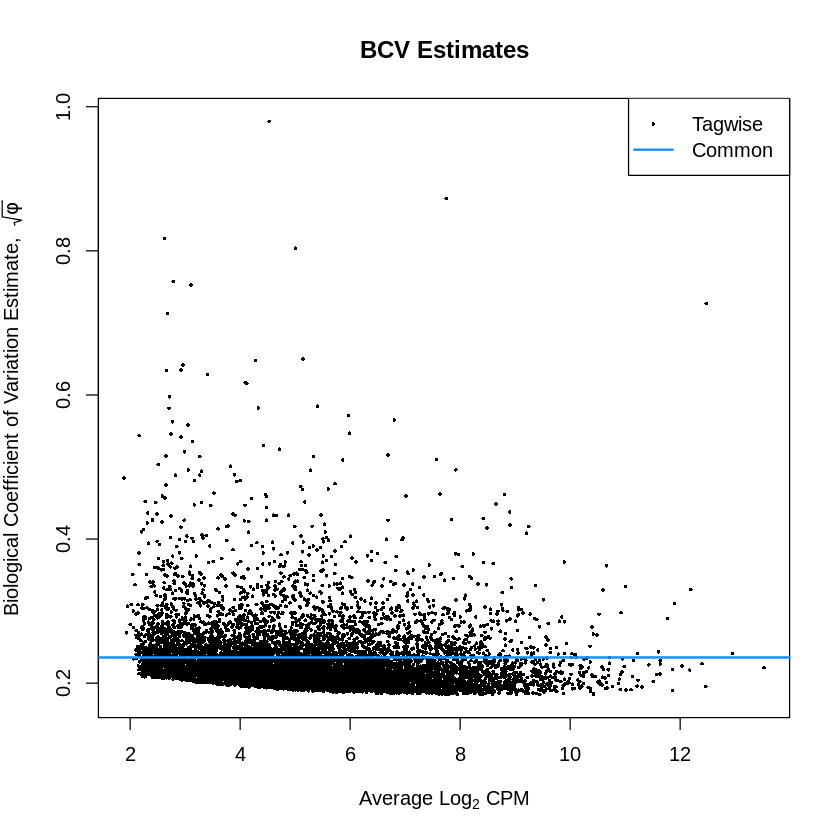

In [17]:
#create MDS plot
if (plot_BCV) {
    cat(paste("Creating edgeR BCV Plot" ,"\n"))#BCVPDFfile <- paste(filename,now,"edgeR_BCV.pdf")
    plotBCV(datafile.dgelist, col.common="dodger blue", cex=0.4, main="BCV Estimates", 
            xlab=expression(Average~Log[2]~CPM), 
            ylab=expression(paste("Biological Coefficient of Variation Estimate,  ", 
                                  sqrt(phi)
                                 )
                           )
           )
}

Creating edgeR MDS Plot 


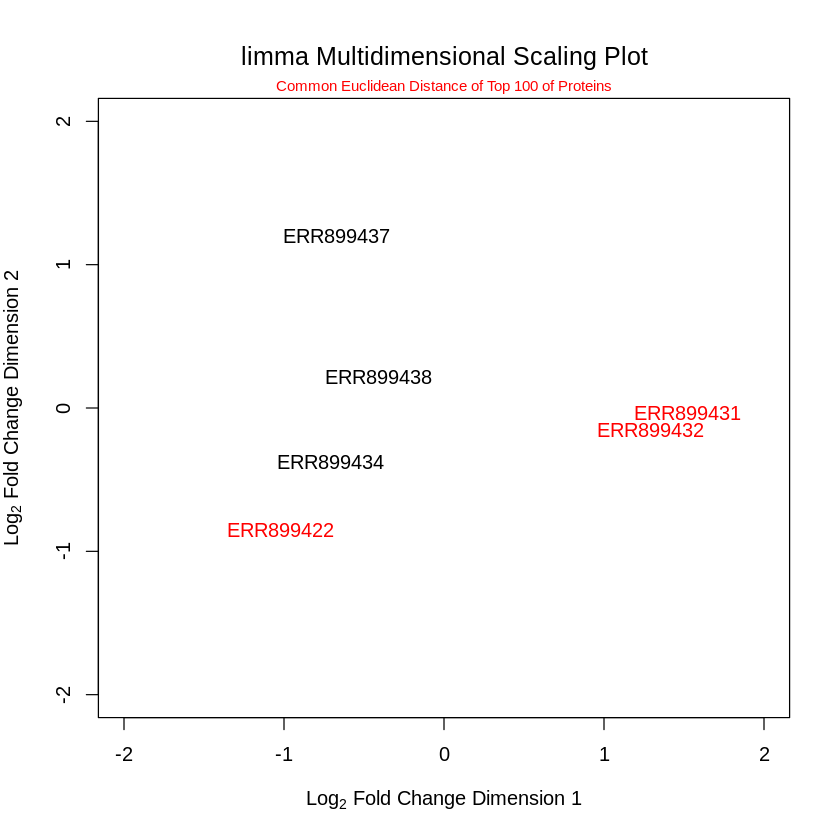

In [18]:
#create MDS plot
if (plot_MDS_MV) {

    cat(paste("Creating edgeR MDS Plot" ,"\n"))
    #MDSPDFfile <- paste(filename,now,"edgeR_MDS.pdf")
    #pdf(file=MDSPDFfile)
    MDStitle <- list(bquote("limma Multidimensional Scaling Plot"), bquote("Common Euclidean Distance of Top 100 of Proteins"))
    plotMDS(datafile.dgelist, top=100, gene.selection="common", col=c(rep("black", g1), rep("red", g1)), xlab=expression(Log[2]~Fold~Change~Dimension~1), ylab=expression(Log[2]~Fold~Change~Dimension~2), main=mtext(do.call(expression, MDStitle), side=3, line=1:0, cex=c(1.25,0.75), col=c("black", "red")), ylim=c(-2, 2), xlim=c(-2, 2))
    #garbage <- dev.off()    
}

Creating edgeR MV Plot 


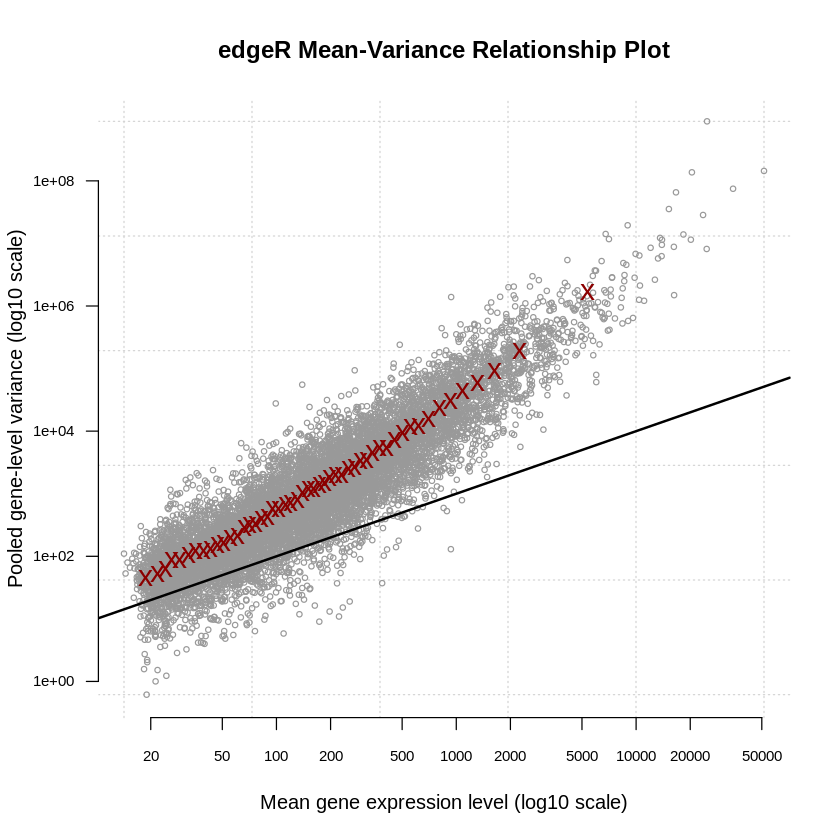

In [19]:
#create Mean Variance plot
if (plot_MDS_MV) {
    cat(paste("Creating edgeR MV Plot" ,"\n"))
    par(cex.axis=0.75, cex.lab=1)
    plotMeanVar(datafile.dgelist, show.raw.vars=T, show.binned.common.disp.vars=F, show.ave.raw.vars=T, nbin=50, bty="n", log.axes=("xy"), las=1, main="edgeR Mean-Variance Relationship Plot", grid(nx=NA, ny=NA))
}

Creating edgeR SMEAR Plot 


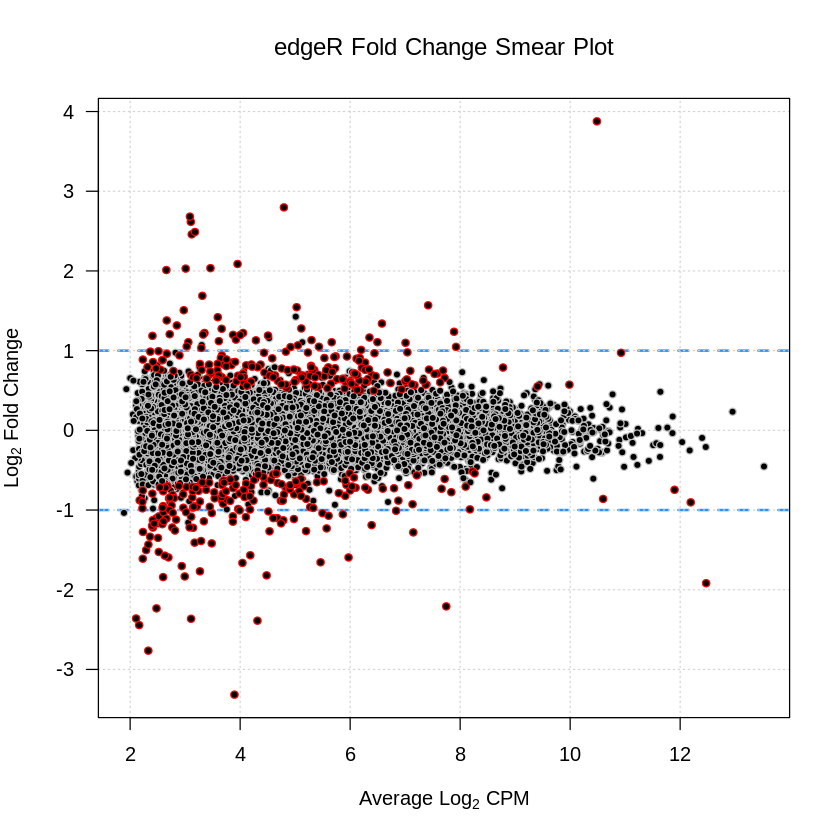

In [20]:
#create SMEAR plot
cat(paste("Creating edgeR SMEAR Plot" ,"\n"))
plotSmear(datafile.dgelist.results , de.tags = detags, las=1, col="gray", cex=0.8, pch=21, bg="black", main = expression(edgeR~Fold~Change~Smear~Plot), xlab=expression(Average~Log[2]~CPM), ylab=expression(Log[2]~Fold~Change), panel.first=c(abline(h = c(-1, 1), lty=2, lwd=2, col = "dodgerblue"), grid()))

In [21]:
if (qvalue_flag == TRUE){
    cat(paste("Calculating edgeR q-Values\n"))
    qobj <- qvalue(final_results$PValue, fdr.level=pvalue, pi0.method="bootstrap")  
    tmp_edger <- cbind(final_results,qobj$qvalues,qobj$significant)
    names(tmp_edger)[names(tmp_edger)=="qobj$qvalues"] <- "e_qvalue"
    names(tmp_edger)[names(tmp_edger)=="qobj$significant"] <- "e_significant"
}

Calculating edgeR q-Values


Plotting edgeR q-Values


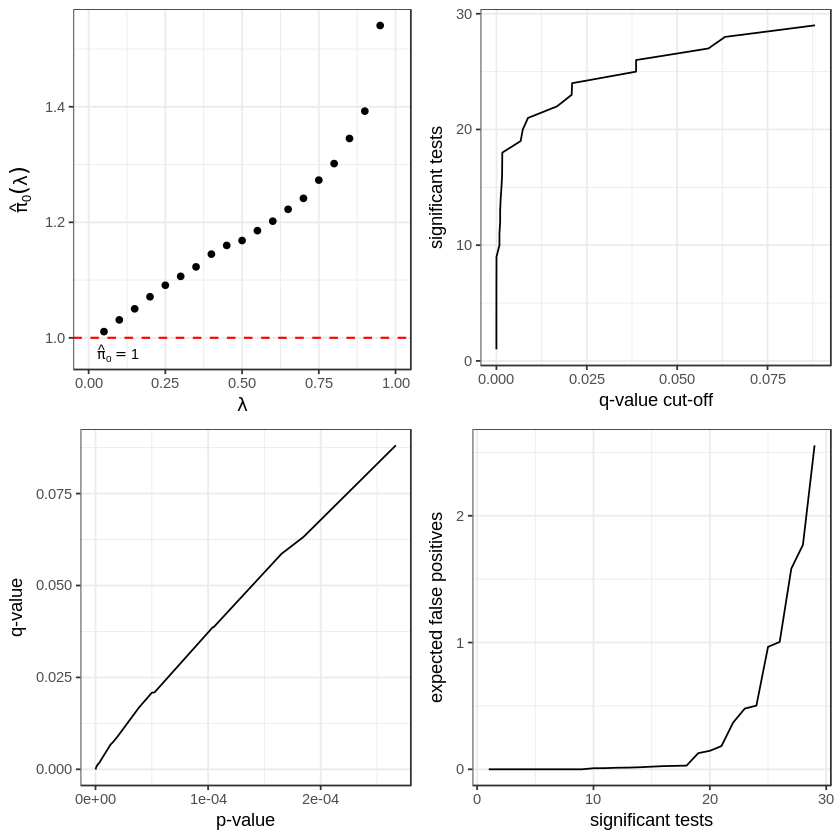

In [22]:
if (qvalue_flag == TRUE){
    cat(paste("Plotting edgeR q-Values\n"))
    plot(qobj)
}

In [23]:
#output final results
cat(paste("Writing edgeR Results Table" ,"\n"))

outfile <- file.path(paste(input_filename,now,"edgeR.csv"))
#edger.out.data <- cbind(substring(row.names(tmp_edger), 4, 9), tmp_edger)
#colnames(edger.out.data)[1] <- c("UniProtID")

output_data_edger <- cbind(geneid = row.names(tmp_edger), tmp_edger)
row.names(output_data_edger) <- NULL 
output_data_edger = output_data_edger[order(output_data_edger$PValue), ]
write.table(output_data_edger , file=outfile, sep=",", col.names=NA)

Writing edgeR Results Table 


In [24]:
head(output_data_edger)

,geneid,ERR899434,ERR899438,ERR899437,ERR899422,ERR899431,ERR899432,logFC,logCPM,PValue,0+1,e_qvalue,e_significant
7226,ENSMUSG00000029687,789,1278,413,11886,11690,11461,3.877,10.487,6.149e-28,1,5.891e-24,TRUE
9323,ENSMUSG00000031375,122,126,176,29,23,29,-2.389,4.315,5.524e-13,-1,2.646e-09,TRUE
6531,ENSMUSG00000040118,14,9,10,51,49,82,2.459,3.120,1.279e-10,1,4.085e-07,TRUE
2098,ENSMUSG00000007682,12,12,6,43,47,93,2.616,3.104,2.363e-10,1,5.660e-07,TRUE
1351,ENSMUSG00000018566,26,49,31,7,6,2,-2.765,2.330,6.267e-10,-1,1.201e-06,TRUE
1912,ENSMUSG00000020581,28,32,30,81,176,369,2.797,4.796,1.640e-09,1,2.619e-06,TRUE


In [25]:
############################################
# Run DESeq Analysis
cat("\n")
cat("Performing DESeq Analysis\n")
#conditions = factor( c(rep(0,g1),rep(1,g2)))
conditions = factor(fac)

cds <- newCountDataSet(filt.counts, conditions)
cds
cat("RLE Normalizing Data\n")
cds <- estimateSizeFactors(cds)

if ((length(selected_columns_a) != 1) & (length(selected_columns_b) != 1)) {
    cds <- estimateDispersions(cds, method="pooled", sharingMode="maximum", fitType="local")
    cat("Pooled Dispersion Estimated\n")
    cat("Local-Linear Dispersion-Mean Relationship Chosen\n")
    cat("Maximum Dispersion Estimate Selected\n")
} else {
    cds <- estimateDispersions(cds, method="blind", sharingMode="fit-only")
	cat("NO REPLICATION -> Blind Dispersion Estimated\n")
    cat("Local-Linear Dispersion-Mean Relationship Chosen\n")
    cat("Maximum Dispersion Estimate Selected\n")
}

res = nbinomTest( cds, conditions[1], tail(conditions, n=1))


Performing DESeq Analysis


CountDataSet (storageMode: environment)
assayData: 9580 features, 6 samples 
  element names: counts 
protocolData: none
phenoData
  sampleNames: ERR899434 ERR899438 ... ERR899432 (6 total)
  varLabels: sizeFactor condition
  varMetadata: labelDescription
featureData: none
experimentData: use 'experimentData(object)'
Annotation:  

RLE Normalizing Data
Pooled Dispersion Estimated
Local-Linear Dispersion-Mean Relationship Chosen
Maximum Dispersion Estimate Selected


Creating DESeq Dispersion-Mean Plot 


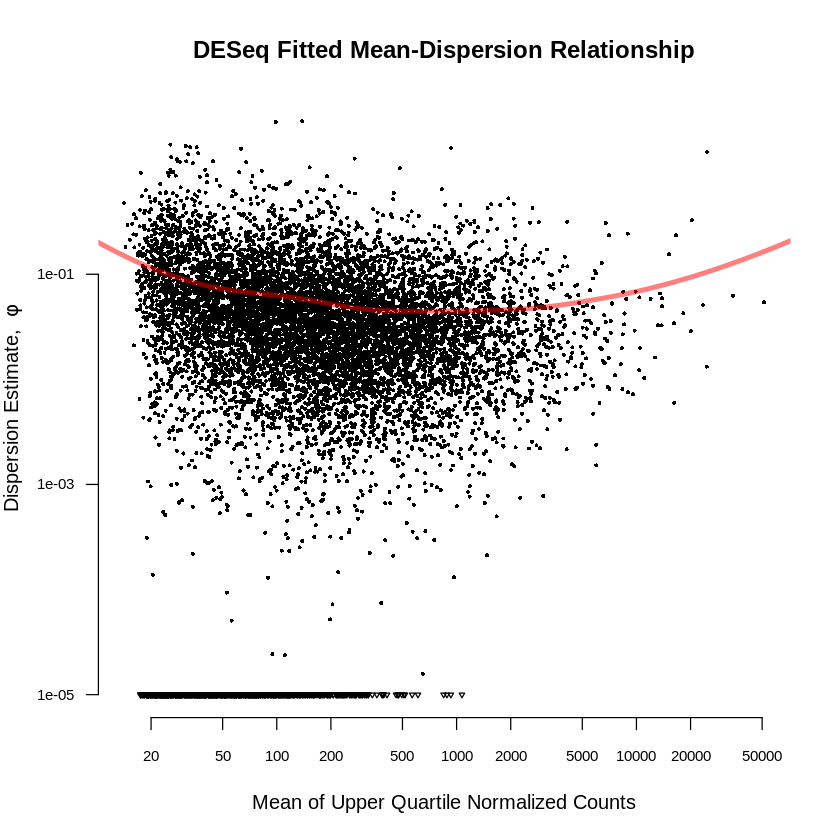

In [26]:
#Create MV plot
if ((g1 != 1) & (g2 != 1)) {
    cat(paste("Creating DESeq Dispersion-Mean Plot" ,"\n"))
    #DESEQDISPPDFfile <- paste(filename,now,"DESeq_Dispersion-Mean.pdf")
    #pdf(file=DESEQDISPPDFfile )
    par(cex.axis=0.75, cex.lab=1)
    plotDispEsts(cds, bty="n", las=1, main="DESeq Fitted Mean-Dispersion Relationship", xlab="Mean of Upper Quartile Normalized Counts", ylab=expression(paste("Dispersion Estimate,  ", phi)))
    #garbage <- dev.off()
}

Creating DESeq MA Plot


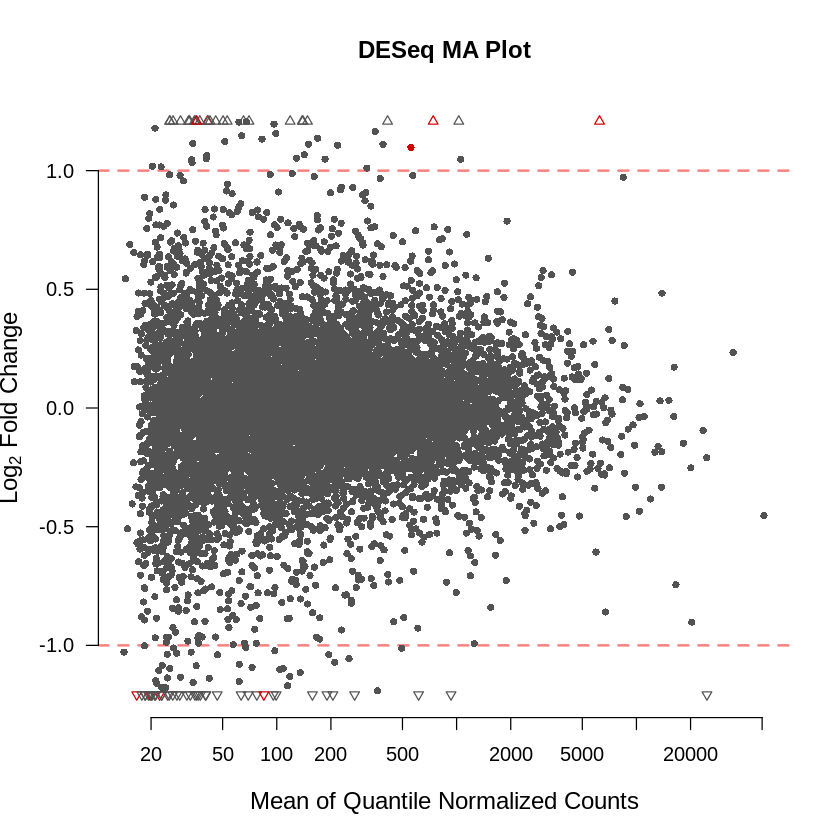

In [27]:
if ((g1 != 1) & (g2 != 1)) {
    cat(paste("Creating DESeq MA Plot\n"))
    #DESEQMAPDFfile <- paste(filename,now,"DESeq_MA.pdf")
    #pdf(file=DESEQMAPDFfile )
    plotMA(res, las=1, bty="n", cex=0.8, linecol = NA, panel.first=c(abline(h = c(-1, 1), lty=2, lwd=2, col="#ff000080")), xlab="Mean of Quantile Normalized Counts", ylab=expression(Log[2]~Fold~Change), main="DESeq MA Plot", cex.lab=1.2)
    #garbage <- dev.off()
}

Calculating DESeq q-Values 


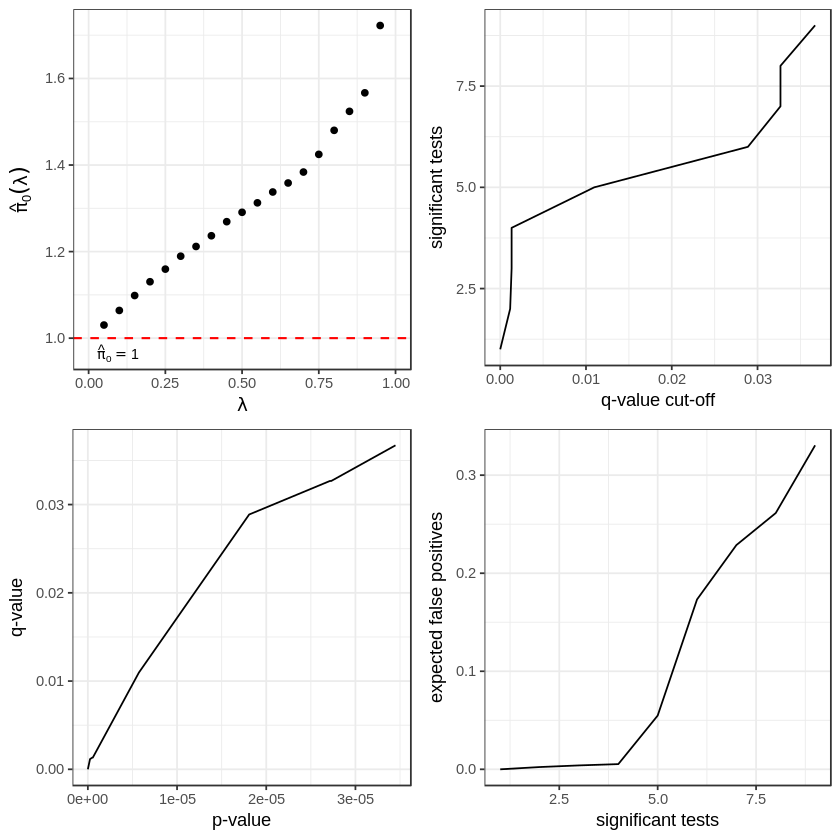

In [28]:
if (qvalue_flag == TRUE){
    qobj <- qvalue(res$pval, fdr.level=pvalue, pi0.method="bootstrap")
    #QPDFfile <- paste(filename,now,"DESeq_qValue.pdf")
    #pdf(file=QPDFfile)
    plot(qobj)
    #garbage <- dev.off()
    cat(paste("Calculating DESeq q-Values" ,"\n"))
    tmp_deseq <- cbind(res,qobj$qvalues,qobj$significant)
    names(tmp_deseq)[names(tmp_deseq)=="qobj$qvalues"] <- "d_qvalue"
    names(tmp_deseq)[names(tmp_deseq)=="qobj$significant"] <- "d_significant"
}

In [29]:
cat("Writing DESeq Results Table\n")
outfile <- file.path(paste(input_filename,now,"DESeq.csv"))
deseq.out.data <- (cbind(tmp_deseq[,1], tmp_deseq[,2:ncol(tmp_deseq)]))
colnames(deseq.out.data)[1] <- c("geneid")
write.table(deseq.out.data[order(deseq.out.data$pval), ] , file=outfile, sep=",", row.names=F)

Writing DESeq Results Table


In [30]:
#options(repr.vector.quote=FALSE)
head(deseq.out.data)

geneid,baseMean,baseMeanA,baseMeanB,foldChange,log2FoldChange,pval,padj,d_qvalue,d_significant
ENSMUSG00000102269,25.75,25.05,26.45,1.0558,0.07829,0.8741,1,1,FALSE
ENSMUSG00000098104,105.98,118.17,93.79,0.7937,-0.33336,0.6520,1,1,FALSE
ENSMUSG00000103922,111.43,112.41,110.46,0.9827,-0.02524,0.9360,1,1,FALSE
ENSMUSG00000033845,336.20,351.32,321.09,0.9140,-0.12980,0.5927,1,1,FALSE
ENSMUSG00000025903,70.91,79.50,62.31,0.7838,-0.35152,0.2946,1,1,FALSE
ENSMUSG00000033813,256.18,231.34,281.03,1.2148,0.28071,0.4531,1,1,FALSE


In [31]:
############################################
# Run baySeq Analysis
cat("Performing baySeq Analysis\n")

replicates <- c(rep(1,g1),rep(2,g2))
groups <- list(NDE = c(rep(1,g1),rep(1,g2)), DE = c(rep(1,g1),rep(2,g2)) )
counts <- as.matrix(filt.counts)

cat("TMM Normalizing Data\n")
CD <- new("countData", data = counts, replicates = replicates, groups = groups)
CD@annotation <- as.data.frame(row.names(filt.counts))
libsizes(CD) <- getLibsizes(CD, estimationType="edgeR")
cl <- NULL
CDP.NBML <- getPriors.NB(CD, samplesize = sampsize, estimation = "QL", cl = cl)
CDPost.NBML <- getLikelihoods(CDP.NBML, pET = 'BIC', cl = cl)
bayseq <- topCounts(CDPost.NBML, number = nrow(CDPost.NBML@annotation), group = "DE")
bayseq.DE <- topCounts(CDPost.NBML, group = "DE", FDR=pvalue)

Performing baySeq Analysis
TMM Normalizing Data


Finding priors...done.
Finding posterior likelihoods...Length of priorReps:0
Length of priorSubset:9580
Length of subset:9580
Length of postRows:9580
Analysing part 1 of 1
Preparing data............................................done.
Estimating likelihoods......done!


.

done.


Creating baySeq MA plot 


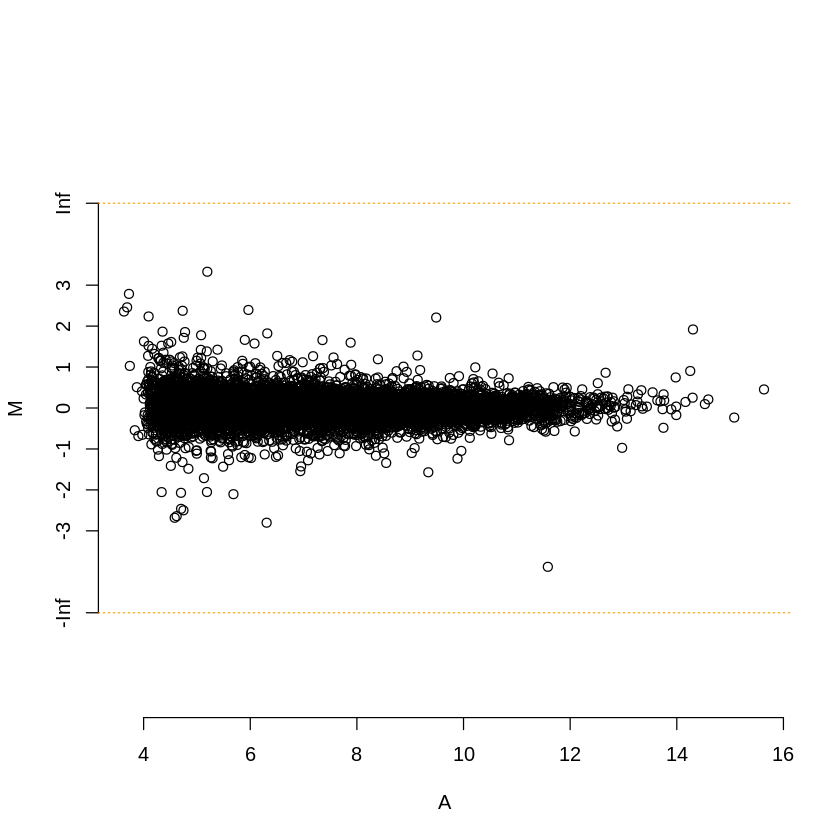

In [32]:
#We need to figure out how the MA plot is determined
cat(paste("Creating baySeq MA plot" ,"\n"))
plotMA.CD(CD, samplesA = "1", samplesB = "2", normaliseData=T, )

Creating baySeq Posterior Probability Plot


Warning message in min(aexp[aexp > -Inf], bexp[bexp > -Inf]):
“no non-missing arguments to min; returning Inf”Warning message in max(aexp, bexp):
“no non-missing arguments to max; returning -Inf”Warning message in max(abs(logData[-infRatios])):
“no non-missing arguments to max; returning -Inf”

ERROR: Error in plot.window(...): need finite 'xlim' values


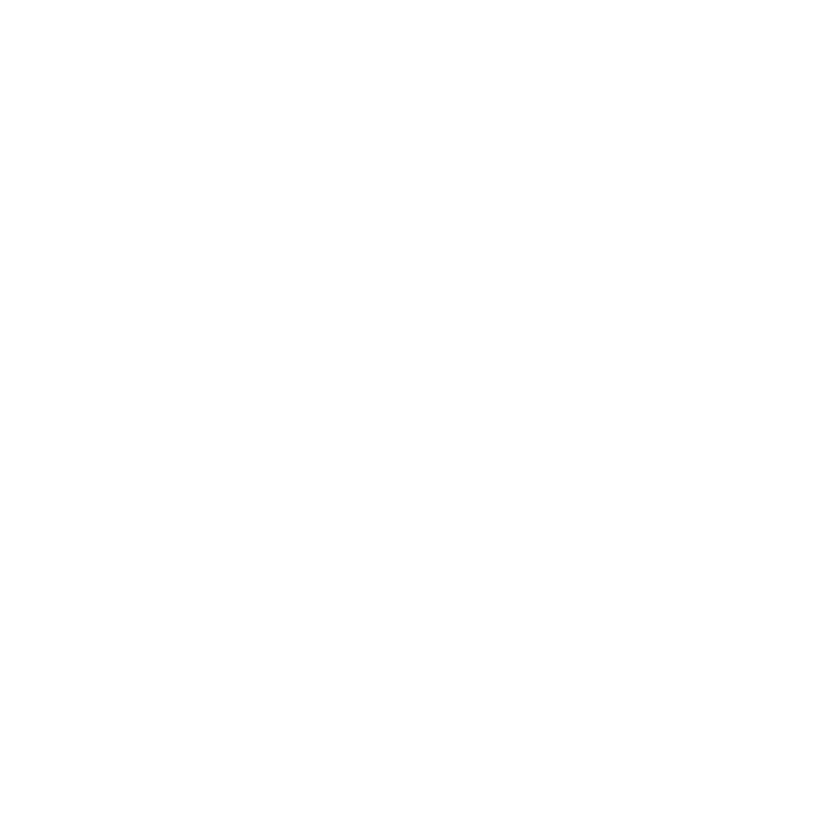

In [38]:
cat("Creating baySeq Posterior Probability Plot\n")
par(cex.axis=0.75, cex.lab=1)
plotPosteriors(CDPost.NBML, group = "DE", pch=21, bg="black", col=c(rep("red", nrow(bayseq.DE)), rep("gray", (nrow(bayseq)-nrow(bayseq.DE)))))

In [39]:
cat("Writing baySeq Results Table\n")
tmp_bayseq <- bayseq
tmp_bayseq$b_significant <- ifelse(tmp_bayseq$FDR <= pvalue, 'TRUE', 'FALSE')
outfile <- paste(input_filename,now,"baySeq.csv")
bayseq.out.data <- (cbind(tmp_bayseq[,1], tmp_bayseq[,2:ncol(tmp_bayseq)]))
colnames(bayseq.out.data)[1] <- c("geneid")
write.table(bayseq.out.data, file=outfile, sep=",", row.names=F)

Writing baySeq Results Table


In [40]:
#options(repr.vector.quote=FALSE)
head(bayseq.out.data)

,geneid,ERR899434,ERR899438,ERR899437,ERR899422,ERR899431,ERR899432,Likelihood,ordering,FDR.DE,FWER.DE,b_significant
ENSMUSG00000031375,ENSMUSG00000031375,122,126,176,29,23,29,0.9907,1>2,0.009272,0.009272,TRUE
ENSMUSG00000029687,ENSMUSG00000029687,789,1278,413,11886,11690,11461,0.9697,2>1,0.019784,0.039287,TRUE
ENSMUSG00000020581,ENSMUSG00000020581,28,32,30,81,176,369,0.9303,2>1,0.036425,0.106257,TRUE
ENSMUSG00000028364,ENSMUSG00000028364,394,448,298,740,1319,1292,0.9115,2>1,0.049453,0.185384,TRUE
ENSMUSG00000069114,ENSMUSG00000069114,34,48,32,74,102,83,0.8354,2>1,0.072481,0.319465,FALSE
ENSMUSG00000053675,ENSMUSG00000053675,128,143,55,29,32,39,0.7734,1>2,0.098169,0.473679,FALSE


In [41]:
############################################
# Combine datasets
cat("Preparing Final Combined Output Files\n")

# extract UniProtIDs
geneids.edgeR <- rownames(tmp_edger)

# How to treat ties in ranking
rankties <- "min"

# extract edgeR pseudocounts and produce edgeR merged data matrix
code1 <- (g1+g2+3)
code2 <- (g1+g2+g1+g2+2)
raw.counts <- tmp_edger[1:(g1+g2)]
raw.counts.names <- paste("Raw_Counts", colnames(raw.counts), sep="_")
edgeR.pseudo.counts <- round(datafile.dgelist$pseudo.counts, digits=3)
edgeR.pseudo.counts.names <- paste("edgeR_Norm_Counts", colnames(edgeR.pseudo.counts), sep="_")
edgeR.stat.data <- tmp_edger[-(1:(g1+g2))]
edgeR.stat.data.names <- paste("edgeR_Analysis", colnames(edgeR.stat.data), sep="_")
mrg.edgeR <- cbind(geneid=rownames(tmp_edger),raw.counts, GeneID=geneids.edgeR, edgeR.pseudo.counts, edgeR.stat.data)
row.names(mrg.edgeR) <- NULL
mrg.edgeR.names <- c("geneid", raw.counts.names, "GeneID_edgeR", edgeR.pseudo.counts.names, edgeR.stat.data.names)
colnames(mrg.edgeR) <- mrg.edgeR.names

# extract DESeq pseudocounts and produce DESeq merged data matrix
code3 <- (g1+g2+2)
DESeq.pseudo.counts <- round(t(t(counts(cds))/sizeFactors(cds)), digits=3)
DESeq.pseudo.counts.names <- paste("DESeq_Norm_Counts", colnames(DESeq.pseudo.counts), sep="_")
geneids.DESeq <- substring(tmp_deseq[,1],4,9)
mrg.DESeq <- cbind(Description=tmp_deseq[,1], GeneID=geneids.DESeq, DESeq.pseudo.counts, tmp_deseq[,-1])
DESeq.stat.data.names <- paste("DESeq_Analysis", colnames(mrg.DESeq)[-(1:code3)], sep="_")
colnames(mrg.DESeq) <- c("geneid", "GeneID_DESeq", DESeq.pseudo.counts.names, DESeq.stat.data.names)

# produce baySeq merged data matrix - Replace any FDR=0 with 1E-8 for downstream analysis
code4 <- (g1+g2+1)
geneids.baySeq <- rownames(tmp_bayseq)
mrg.baySeq <- cbind(Description = rownames(tmp_bayseq),GeneID=geneids.baySeq, tmp_bayseq[,-(1:code4)])
baySeq.stat.data.names <- paste("baySeq_Analysis", colnames(mrg.baySeq)[-c(1,2)], sep="_")
colnames(mrg.baySeq) <- c("geneid","GeneID_baySeq", baySeq.stat.data.names)
mrg.baySeq$baySeq_Analysis_FDR.DE[mrg.baySeq$baySeq_Analysis_FDR.DE == 0] <- 1.00E-8

# Merge edgeR, DESeq and baySeq data
combined_table1 <- merge(mrg.edgeR, mrg.DESeq, by.x="geneid", by.y="geneid")
combined_table2 <- merge(combined_table1, mrg.baySeq, by.x="geneid", by.y="geneid")

cat("Calculating the MultiSpec q-Value\n")
Multi_Seq_Analysis_Med_qvalue <- rep(NA, nrow(combined_table2))
for (i in 1:nrow(combined_table2)){
Multi_Seq_Analysis_Med_qvalue[i] <- median(c(combined_table2$edgeR_Analysis_e_qvalue[i], combined_table2$DESeq_Analysis_d_qvalue[i], combined_table2$baySeq_Analysis_FDR.DE[i]))
}

combined_table2$Multi_Seq_Analysis_Med_qvalue <- Multi_Seq_Analysis_Med_qvalue
combined_table2$Multi_Spec_significant <- ifelse(combined_table2$Multi_Seq_Analysis_Med_qvalue <= pvalue, 'TRUE', 'FALSE')

cat("Calculate the MultiSpec Rank-Sum\n")
combined_table2$edgeR_Analysis_Rank <- rank(combined_table2$edgeR_Analysis_e_qvalue, ties.method=rankties)
combined_table2$DESeq_Analysis_Rank <- rank(combined_table2$DESeq_Analysis_d_qvalue, ties.method=rankties)
combined_table2$baySeq_Analysis_Rank <- rank(combined_table2$baySeq_Analysis_FDR.DE, ties.method=rankties)
Multi_Seq_Analysis_RankSum <- rep(NA, nrow(combined_table2))
for (i in 1:nrow(combined_table2)){
Multi_Seq_Analysis_RankSum[i] <- sum(c(combined_table2$edgeR_Analysis_Rank[i], combined_table2$DESeq_Analysis_Rank[i], combined_table2$baySeq_Analysis_Rank[i]))
}

combined_table2$Multi_Seq_Analysis_RankSum <- Multi_Seq_Analysis_RankSum
combined_table2$Multi_Seq_Analysis_Med_qvalue_Rank <- rank(combined_table2$Multi_Seq_Analysis_Med_qvalue, ties.method=rankties)

cat("Writing Final Results Table\n")
outfile <- paste(input_filename,now,"Final_Results.csv")
MultiSpecResults <- combined_table2[order(combined_table2$Multi_Seq_Analysis_Med_qvalue_Rank), ]
write.table(MultiSpecResults, file=outfile, sep=",", row.names=F)

Preparing Final Combined Output Files
Calculating the MultiSpec q-Value
Calculate the MultiSpec Rank-Sum
Writing Final Results Table


In [42]:
# Write out a simplified file
cat("Writing Combined Significance Table\n")
final_sig_data <- data.frame(as.character(combined_table2$geneid), combined_table2$geneid, combined_table2$edgeR_Analysis_e_significant, combined_table2$DESeq_Analysis_d_significant, combined_table2$baySeq_Analysis_b_significant, as.numeric(combined_table2$edgeR_Analysis_e_qvalue), as.numeric(combined_table2$DESeq_Analysis_d_qvalue), as.numeric(combined_table2$baySeq_Analysis_FDR.DE), as.numeric(combined_table2$Multi_Seq_Analysis_RankSum), as.numeric(combined_table2$Multi_Seq_Analysis_Med_qvalue_Rank))
colnames(final_sig_data) <- c("geneid","GeneID", "e_significant","d_significant","b_significant", "e_qvalue", "d_qvalue", "b_FDR", "Multi_Spec_RankSum", "MultiSpec_Overall_Rank")
outfile <- paste(input_filename,now,"final_significant.csv")
write.table(final_sig_data[order(final_sig_data$MultiSpec_Overall_Rank), ], file=outfile, sep=",", row.names=F)

Writing Combined Significance Table


Creating Component Venn Diagram of Significant IDs


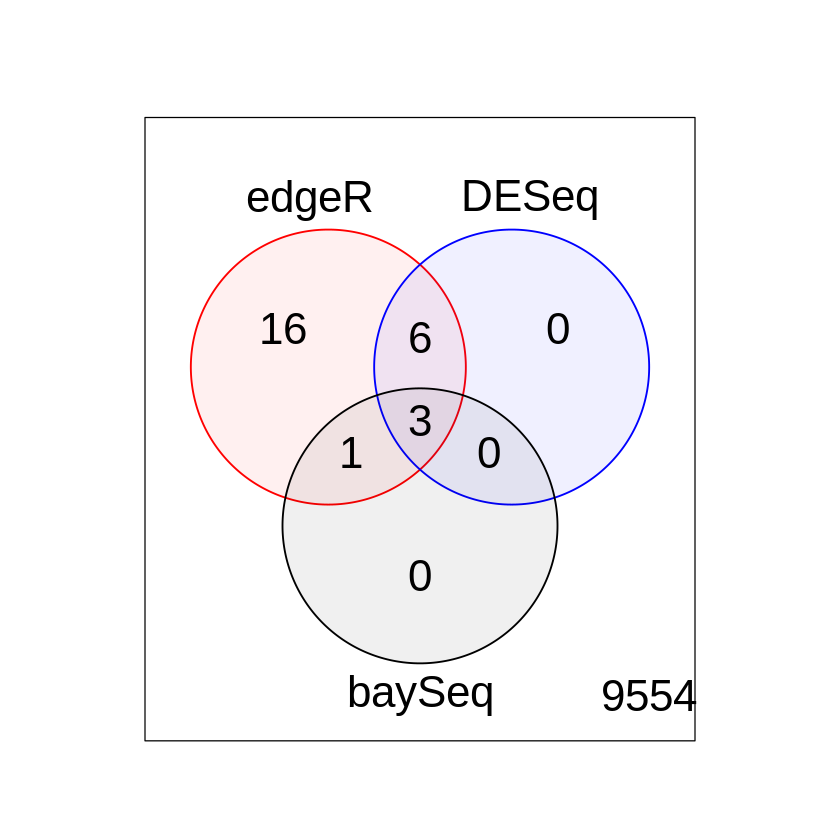

In [43]:
# Write out combined Venn Diagram for edgeR, DESeq and baySeq
cat("Creating Component Venn Diagram of Significant IDs\n")
Multi_Spec_qvalues <- cbind(combined_table2$edgeR_Analysis_e_significant, combined_table2$DESeq_Analysis_d_significant, combined_table2$baySeq_Analysis_b_significant)
venn_counts2 <-vennCounts(type.convert(Multi_Spec_qvalues))
#VENNPDFfile <- paste(filename, now, "component_Venn.pdf")
#pdf(file=VENNPDFfile )
vennDiagram(venn_counts2, include="both", names=c("edgeR", "DESeq", "baySeq"), counts.col=c("black"), circle.col=c("red", "blue", "black"), cex=2.2, lwd=1.5)
#garbage <- dev.off()

Creating MultiSpec Venn Diagram of Significant IDs


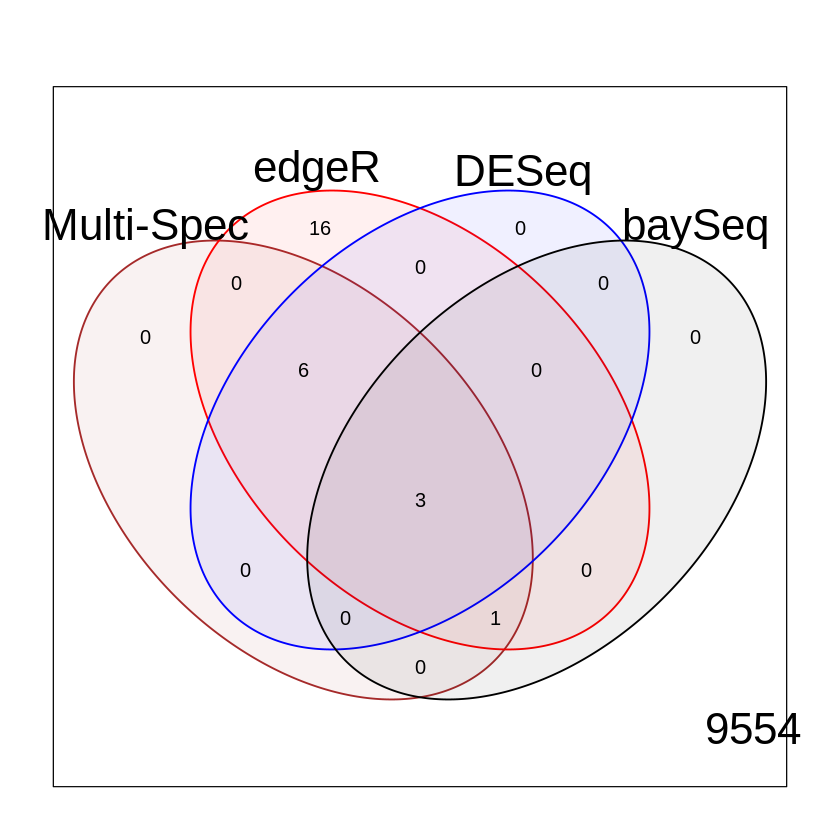

In [44]:
# Write out combined Venn Diagram for edgeR, DESeq and baySeq
cat("Creating MultiSpec Venn Diagram of Significant IDs\n")
Multi_Spec_qvalues <- cbind(combined_table2$Multi_Spec_significant, combined_table2$edgeR_Analysis_e_significant, combined_table2$DESeq_Analysis_d_significant, combined_table2$baySeq_Analysis_b_significant)
venn_counts3 <-vennCounts(type.convert(Multi_Spec_qvalues))
#VENNPDFfile <- paste(filename, now, "final_combined_Venn.pdf")
#pdf(file=VENNPDFfile )
par(mar=c(1,1,1,1))
vennDiagram(venn_counts3, include="both", names=c("Multi-Spec", "edgeR", "DESeq", "baySeq"), counts.col=c("black"), circle.col=c("brown", "red", "blue", "black"), cex=2.2, lwd=1.5)
#garbage <- dev.off()

In [45]:
# Produce MultiSpec Rank/Origin Graphic
Plot.MultiSpecResults <- subset(MultiSpecResults, Multi_Seq_Analysis_Med_qvalue <= pvalue)
cat("Creating MultiSpec Origin Plot\n")
x <- vector(mode="numeric", length=nrow(Plot.MultiSpecResults))
for ( i in seq(1:nrow(Plot.MultiSpecResults))){
    if (Plot.MultiSpecResults$Multi_Seq_Analysis_Med_qvalue[i] == Plot.MultiSpecResults$edgeR_Analysis_e_qvalue[i]){
        x[i] <- 1
    }	else if (Plot.MultiSpecResults$Multi_Seq_Analysis_Med_qvalue[i] == Plot.MultiSpecResults$DESeq_Analysis_d_qvalue[i]){
        x[i] <- 2
    }	else if (Plot.MultiSpecResults$Multi_Seq_Analysis_Med_qvalue[i] == Plot.MultiSpecResults$baySeq_Analysis_FDR.DE[i]){
        x[i] <- 3
    }	else {
        x[i] <- 4
    }
}
y <- cbind(seq(1:nrow(Plot.MultiSpecResults)), x)
y1 <- subset(y, y[,2]==1)
y2 <- subset(y, y[,2]==2)
y3 <- subset(y, y[,2]==3)
plot.colors <- c("black", "red", "blue", "grey50")
plot.pchs <- c(16,17,18)

lpe = -log(Plot.MultiSpecResults$edgeR_Analysis_e_qvalue,10)
lpe[!is.finite(lpe)] = max(lpd[is.finite(lpe)])

lpd = -log(Plot.MultiSpecResults$DESeq_Analysis_d_qvalue,10)
lpd[!is.finite(lpd)] = max(lpd[is.finite(lpd)])

lpb = -log(Plot.MultiSpecResults$baySeq_Analysis_FDR.DE,10)
lpb[!is.finite(lpb)] = max(lpd[is.finite(lpb)])

ymax <- max(lpe,lpd,lpb)


#MultiSpecOriginPlot <- paste(filename, now, "MultiSpec_Origin_Plot.pdf")
#pdf(file=MultiSpecOriginPlot, height=11, width=8.5)
layout(mat=matrix(c(1,2),2,1, byrow=T), heights=c(3,7), respect=F)
par(mar=c(0,6,4,1) + 0.1)
plot(y[,1], y[,2], type="n", xlab="", ylab="", xaxt="n",  yaxt="n")
axis(2, c(1,2,3), labels=c("edgeR", "DESeq", "baySeq"), las=1, cex.axis=1.2)
title(ylab="Statistical Platform", cex.lab=1.5, line=4.6)
title(main="MultiSpec q-Value Origin", cex.main=2)
points(y1[,1], y1[,2], col=plot.colors[1], pch=plot.pchs[1])
points(y2[,1], y2[,2], col=plot.colors[2], pch=plot.pchs[2])
points(y3[,1], y3[,2], col=plot.colors[3], pch=plot.pchs[3])

par(mar=c(5,6,0,1) + 0.1)
plot(seq(1:nrow(Plot.MultiSpecResults)), seq(1:nrow(Plot.MultiSpecResults)), type="n", ylab="", xlab="", cex.axis=1.4, las=1, ylim=c(0,ymax))
title(xlab="MultiSpec Rank (q-value)", cex.lab=1.5, line=3.5)
title(ylab=expression(-Log[10]~q-Value), cex.lab=1.5, line=4.6)
points(seq(1:nrow(Plot.MultiSpecResults)), -log(Plot.MultiSpecResults$edgeR_Analysis_e_qvalue,10), pch=plot.pchs[1], cex=0.8, col=plot.colors[1])
points(seq(1:nrow(Plot.MultiSpecResults)), -log(Plot.MultiSpecResults$DESeq_Analysis_d_qvalue,10), pch=plot.pchs[2], cex=0.8, col=plot.colors[2])
points(seq(1:nrow(Plot.MultiSpecResults)), -log(Plot.MultiSpecResults$baySeq_Analysis_FDR.DE,10), pch=plot.pchs[3], cex=0.8, col=plot.colors[3])
points(seq(1:nrow(Plot.MultiSpecResults)), -log(Plot.MultiSpecResults$Multi_Seq_Analysis_Med_qvalue,10), type="l", col=plot.colors[4], lwd=3)
legend("topright", c("edgeR", "DESeq", "baySeq", "MultiSpec"), pch=c(plot.pchs, NA), cex=1.5, lwd=c(NA,NA,NA,3), col=plot.colors)
#garbage <- dev.off()

Creating MultiSpec Origin Plot


ERROR: Error in eval(expr, envir, enclos): object 'lpd' not found


Calculating Spearman Coorelations for q-Values/FDR
Creating Spearman q-Value Coorelation Plot matrix


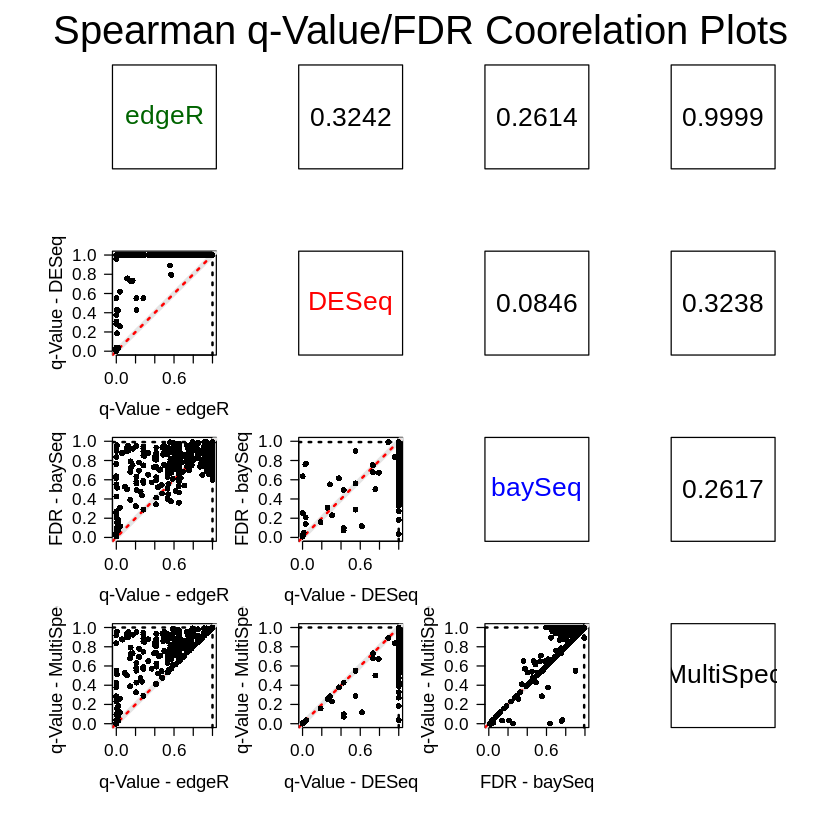

In [46]:
# Produce MultiSpec q-Value Spearman Coorelation Graphic
cat("Calculating Spearman Coorelations for q-Values/FDR\n")
eq <- MultiSpecResults$edgeR_Analysis_e_qvalue
dq <- MultiSpecResults$DESeq_Analysis_d_qvalue
bq <- MultiSpecResults$baySeq_Analysis_FDR.DE
mq <- MultiSpecResults$Multi_Seq_Analysis_Med_qvalue
cor.e.d <- cor(eq, dq, method="spearman")
cor.e.b <- cor(eq, bq, method="spearman")
cor.e.m <- cor(eq, mq, method="spearman")
cor.d.b <- cor(dq, bq, method="spearman")
cor.d.m <- cor(dq, mq, method="spearman")
cor.b.m <- cor(bq, mq, method="spearman")
cat("Creating Spearman q-Value Coorelation Plot matrix\n")

#SpearmanCoorlations <- paste(filename, now, "MultiSpec_q-Value_Coorelation_Matrix.pdf")
#pdf(SpearmanCoorlations, height=10, width=10)
cor.margs <- c(4,4,1,1) + 0.1
par(mfrow=c(4,4), mar=cor.margs, oma=c(3,3,3,3))
plot(2, xaxt="n", yaxt="n", xlab="", ylab="", ylim=c(0,1), xlim=c(0,1))
text(0.5, 0.5, "edgeR", col="darkgreen", cex=2)
plot(2, type="n", xaxt="n", yaxt="n", xlab="", ylab="", ylim=c(0,1), xlim=c(0,1))
text(0.5,0.5, round(cor.e.d, 4), cex=2)
plot(2, type="n", xaxt="n", yaxt="n", xlab="", ylab="", ylim=c(0,1), xlim=c(0,1))
text(0.5,0.5, round(cor.e.b, 4), cex=2)
plot(2, type="n", xaxt="n", yaxt="n", xlab="", ylab="", ylim=c(0,1), xlim=c(0,1))
text(0.5,0.5, round(cor.e.m, 4), cex=2)
plot(eq, dq, ylim=c(0,1), xlim=c(0,1), cex.axis=1.3, cex.lab=1.4, ylab="q-Value - DESeq", xlab="q-Value - edgeR", las=1, type="n")
abline(h=max(dq), lty=3, lwd=2)
abline(v=max(eq), lty=3, lwd=2)
abline(0,1, lwd=4, col="grey90")
abline(0,1, lty=3, lwd=2, col="red")
points(eq, dq, pch=16)
plot(2, xaxt="n", yaxt="n", xlab="", ylab="", ylim=c(0,1), xlim=c(0,1))
text(0.5, 0.5, "DESeq", col="red", cex=2)
plot(2, xaxt="n", yaxt="n", xlab="", ylab="", ylim=c(0,1), xlim=c(0,1))
text(0.5,0.5, round(cor.d.b, 4), cex=2)
plot(2, xaxt="n", yaxt="n", xlab="", ylab="", ylim=c(0,1), xlim=c(0,1))
text(0.5,0.5, round(cor.d.m, 4), cex=2)
plot(eq, bq, ylim=c(0,1), xlim=c(0,1), cex.axis=1.3, cex.lab=1.4, ylab="FDR - baySeq", xlab="q-Value - edgeR", las=1, type="n")
abline(h=max(bq), lty=3, lwd=2)
abline(v=max(eq), lty=3, lwd=2)
abline(0,1, lwd=4, col="grey90")
abline(0,1, lty=3, lwd=2, col="red")
points(eq, bq, pch=16)
plot(dq, bq, ylim=c(0,1), xlim=c(0,1), cex.axis=1.3, cex.lab=1.4, ylab="FDR - baySeq", xlab="q-Value - DESeq", las=1, type="n")
abline(h=max(bq), lty=3, lwd=2)
abline(v=max(dq), lty=3, lwd=2)
abline(0,1, lwd=4, col="grey90")
abline(0,1, lty=3, lwd=2, col="red")
points(dq, bq, pch=16)
plot(2, xaxt="n", yaxt="n", xlab="", ylab="", ylim=c(0,1), xlim=c(0,1))
text(0.5, 0.5, "baySeq", col="blue", cex=2)
plot(2, xaxt="n", yaxt="n", xlab="", ylab="", ylim=c(0,1), xlim=c(0,1))
text(0.5,0.5, round(cor.b.m, 4), cex=2)

plot(eq, mq, ylim=c(0,1), xlim=c(0,1), cex.axis=1.3, cex.lab=1.4, ylab="q-Value - MultiSpec", xlab="q-Value - edgeR", las=1, type="n")
abline(h=max(mq), lty=3, lwd=2)
abline(v=max(eq), lty=3, lwd=2)
abline(0,1, lwd=4, col="grey90")
abline(0,1, lty=3, lwd=2, col="red")
points(eq, mq, pch=16)

plot(dq, mq, ylim=c(0,1), xlim=c(0,1), cex.axis=1.3, cex.lab=1.4, ylab="q-Value - MultiSpec", xlab="q-Value - DESeq", las=1, type="n")
abline(h=max(mq), lty=3, lwd=2)
abline(v=max(dq), lty=3, lwd=2)
abline(0,1, lwd=4, col="grey90")
abline(0,1, lty=3, lwd=2, col="red")
points(dq, mq, pch=16)

plot(bq, mq, ylim=c(0,1), xlim=c(0,1), cex.axis=1.3, cex.lab=1.4, ylab="q-Value - MultiSpec", xlab="FDR - baySeq", las=1, type="n")
abline(h=max(mq), lty=3, lwd=2)
abline(v=max(bq), lty=3, lwd=2)
abline(0,1, lwd=4, col="grey90")
abline(0,1, lty=3, lwd=2, col="red")
points(bq, mq, pch=16)

plot(2, xaxt="n", yaxt="n", xlab="", ylab="", ylim=c(0,1), xlim=c(0,1))
text(0.5, 0.5, "MultiSpec", cex=2)
mtext("Spearman q-Value/FDR Coorelation Plots", outer=T, cex=2)
#garbage <- dev.off()

# Produce MultiSpec Orphan Graphics
edgeR.orphan.cans <- subset(MultiSpecResults, edgeR_Analysis_e_qvalue <= pvalue & DESeq_Analysis_d_qvalue > pvalue & baySeq_Analysis_FDR.DE > pvalue)
edgeR.orphan <- data.frame(e=edgeR.orphan.cans$edgeR_Analysis_e_qvalue, d=edgeR.orphan.cans$DESeq_Analysis_d_qvalue, b=edgeR.orphan.cans$baySeq_Analysis_FDR.DE)
DESeq.orphan.cans <- subset(MultiSpecResults, edgeR_Analysis_e_qvalue > pvalue & DESeq_Analysis_d_qvalue <= pvalue & baySeq_Analysis_FDR.DE > pvalue)
DESeq.orphan <- data.frame(e=DESeq.orphan.cans$edgeR_Analysis_e_qvalue, d=DESeq.orphan.cans$DESeq_Analysis_d_qvalue, b=DESeq.orphan.cans$baySeq_Analysis_FDR.DE)
baySeq.orphan.cans <- subset(MultiSpecResults, edgeR_Analysis_e_qvalue > pvalue & DESeq_Analysis_d_qvalue > pvalue & baySeq_Analysis_FDR.DE <= pvalue)
baySeq.orphan <- data.frame(e=baySeq.orphan.cans$edgeR_Analysis_e_qvalue, d=baySeq.orphan.cans$DESeq_Analysis_d_qvalue, b=baySeq.orphan.cans$baySeq_Analysis_FDR.DE)

Creating MultiSpec Orphan Plots
  Plotting 16 edgeR Orphan Candidates 
  No DESeq Orphan Candidnates were Identified
  No baySeq Orphan Candidnates were Identified


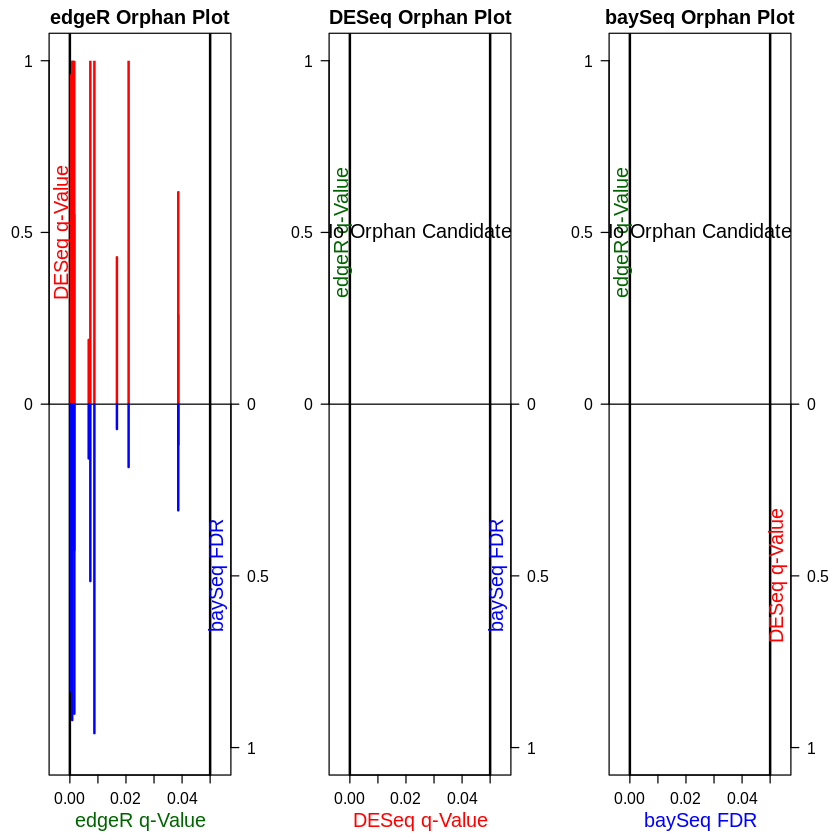

In [47]:
cat("Creating MultiSpec Orphan Plots\n")
orphan.plot.range <- c(0,pvalue)
orphan.x.lims <- c(-0.1*orphan.plot.range[2],1.1*orphan.plot.range[2])
par(mfrow=c(1,3))
plot.margins <- c(4,3,2,3)
if (nrow(edgeR.orphan) >=1){
	par(mar=plot.margins + 0.1)
	plot(1,1, xlim=orphan.x.lims, ylim=c(-1,1), type="n", yaxt="n", xlab="", ylab="", cex.axis=1.2)
	abline(h=0)
	abline(v=orphan.plot.range, lwd=2)
	axis(4, at=c(0,-0.5, -1), labels=c("0","0.5","1"), las=1, cex.axis=1.2)
	axis(2, at=c(0,0.5, 1), labels=c("0","0.5","1"), las=1, cex.axis=1.2)
	text(x=((orphan.x.lims[1]-orphan.plot.range[1])/2), y=0.5, "DESeq q-Value", cex=1.5, srt=90, col="red")
	text(x=orphan.plot.range[2]+((orphan.x.lims[2]-orphan.plot.range[2])/2), y=-0.5, "baySeq FDR", cex=1.5, srt=90, col="blue")
	title(main="edgeR Orphan Plot", cex.main=1.5)
	title(xlab="edgeR q-Value", cex.lab=1.5, line=2.5, col.lab="darkgreen")
    for (i in seq(1:nrow(edgeR.orphan))){
        y1.1 <- edgeR.orphan$d[i]
        y1.2 <- -edgeR.orphan$b[i]
        y2 <- 0
        x1 <- edgeR.orphan$e[i]
        x2 <- edgeR.orphan$e[i]
        clip(orphan.plot.range[1], orphan.plot.range[2], -1, 1)
        lines(y=c(y1.1, y2), x=c(x1, x2), lwd=2, col="red")
        lines(y=c(y1.2, y2), x=c(x1, x2), lwd=2, col="blue")
    }
    cat(paste("  Plotting", nrow(edgeR.orphan), "edgeR Orphan Candidates", sep=" "),"\n")
    
} else {
	par(mar=plot.margins + 0.1)
	plot(1,1, xlim=orphan.x.lims, ylim=c(-1,1), type="n", yaxt="n", xlab="", ylab="", cex.axis=1.2)
	abline(h=0)
	abline(v=orphan.plot.range, lwd=2)
	axis(4, at=c(0,-0.5, -1), labels=c("0","0.5","1"), las=1, cex.axis=1.2)
	axis(2, at=c(0,0.5, 1), labels=c("0","0.5","1"), las=1, cex.axis=1.2)
	text(x=((orphan.x.lims[1]-orphan.plot.range[1])/2), y=0.5, "DESeq q-Value", cex=1.5, srt=90, col="red")
	text(x=orphan.plot.range[2]+((orphan.x.lims[2]-orphan.plot.range[2])/2), y=-0.5, "baySeq FDR", cex=1.5, srt=90, col="blue")
	title(main="edgeR orphan Plot", cex.main=1.5)
	title(xlab="edgeR q-Value", cex.lab=1.5, line=2.5, col.lab="darkgreen")
	text(x=(orphan.plot.range[2]-orphan.plot.range[1])/2, y=0.5, "No Orphan Candidates", cex=1.5)
    cat("  No edgeR Orphan Candidnates were Identified\n")
}

if (nrow(DESeq.orphan) >=1){
	par(mar=plot.margins + 0.1)
	plot(1,1, xlim=orphan.x.lims, ylim=c(-1,1), type="n", yaxt="n", xlab="", ylab="", cex.axis=1.2)
	abline(h=0)
	abline(v=orphan.plot.range, lwd=2)
	axis(4, at=c(0,-0.5, -1), labels=c("0","0.5","1"), las=1, cex.axis=1.2)
	axis(2, at=c(0,0.5, 1), labels=c("0","0.5","1"), las=1, cex.axis=1.2)
	text(x=((orphan.x.lims[1]-orphan.plot.range[1])/2), y=0.5, "edgeR q-Value", cex=1.5, srt=90, col="darkgreen")
	text(x=orphan.plot.range[2]+((orphan.x.lims[2]-orphan.plot.range[2])/2), y=-0.5, "baySeq FDR", cex=1.5, srt=90, col="blue")
	title(main="DESeq Orphan Plot", cex.main=1.5)
	title(xlab="DESeq q-Value", cex.lab=1.5, line=2.5, col.lab="red")
    for (i in seq(1:nrow(DESeq.orphan))){
        y1.1 <- DESeq.orphan$e[i]
        y1.2 <- -DESeq.orphan$b[i]
        y2 <- 0
        x1 <- DESeq.orphan$d[i]
        x2 <- DESeq.orphan$d[i]
        clip(orphan.plot.range[1], orphan.plot.range[2], -1, 1)
        lines(y=c(y1.1, y2), x=c(x1, x2), lwd=2, col="darkgreen")
        lines(y=c(y1.2, y2), x=c(x1, x2), lwd=2, col="blue")
    }
    cat(paste("  Plotting", nrow(DESeq.orphan), "DESeq Orphan Candidates", sep=" "),"\n")
} else {
	par(mar=plot.margins + 0.1)
	plot(1,1, xlim=orphan.x.lims, ylim=c(-1,1), type="n", yaxt="n", xlab="", ylab="", cex.axis=1.2)
	abline(h=0)
	abline(v=orphan.plot.range, lwd=2)
	axis(4, at=c(0,-0.5, -1), labels=c("0","0.5","1"), las=1, cex.axis=1.2)
	axis(2, at=c(0,0.5, 1), labels=c("0","0.5","1"), las=1, cex.axis=1.2)
	text(x=((orphan.x.lims[1]-orphan.plot.range[1])/2), y=0.5, "edgeR q-Value", cex=1.5, srt=90, col="darkgreen")
	text(x=orphan.plot.range[2]+((orphan.x.lims[2]-orphan.plot.range[2])/2), y=-0.5, "baySeq FDR", cex=1.5, srt=90, col="blue")
	title(main="DESeq Orphan Plot", cex.main=1.5)
	title(xlab="DESeq q-Value", cex.lab=1.5, line=2.5, col.lab="red")
	text(x=(orphan.plot.range[2]-orphan.plot.range[1])/2, y=0.5, "No Orphan Candidates", cex=1.5)
    cat("  No DESeq Orphan Candidnates were Identified\n")
}

if (nrow(baySeq.orphan) >=1){
	par(mar=plot.margins + 0.1)
	plot(1,1, xlim=orphan.x.lims, ylim=c(-1,1), type="n", yaxt="n", xlab="", ylab="", cex.axis=1.2)
	abline(h=0)
	abline(v=orphan.plot.range, lwd=2)
	axis(4, at=c(0,-0.5, -1), labels=c("0","0.5","1"), las=1, cex.axis=1.2)
	axis(2, at=c(0,0.5, 1), labels=c("0","0.5","1"), las=1, cex.axis=1.2)
	text(x=((orphan.x.lims[1]-orphan.plot.range[1])/2), y=0.5, "edgeR q-Value", cex=1.5, srt=90, col="darkgreen")
	text(x=orphan.plot.range[2]+((orphan.x.lims[2]-orphan.plot.range[2])/2), y=-0.5, "DESeq q-Value", cex=1.5, srt=90, col="red")
	title(main="baySeq Orphan Plot", cex.main=1.5)
	title(xlab="baySeq FDR", cex.lab=1.5, line=2.5, , col.lab="blue")
    
    for (i in seq(1:nrow(baySeq.orphan))){
        y1.1 <- baySeq.orphan$e[i]
        y1.2 <- -baySeq.orphan$d[i]
        y2 <- 0
        x1 <- baySeq.orphan$b[i]
        x2 <- baySeq.orphan$b[i]
        clip(orphan.plot.range[1], orphan.plot.range[2], -1, 1)
        lines(y=c(y1.1, y2), x=c(x1, x2), lwd=2, col="darkgreen")
        lines(y=c(y1.2, y2), x=c(x1, x2), lwd=2, col="red")
    }
    cat(paste("  Plotting", nrow(baySeq.orphan), "baySeq Orphan Candidates", sep=" "),"\n")
} else {
	par(mar=plot.margins + 0.1)
	plot(1,1, xlim=orphan.x.lims, ylim=c(-1,1), type="n", yaxt="n", xlab="", ylab="", cex.axis=1.2)
	abline(h=0)
	abline(v=orphan.plot.range, lwd=2)
	axis(4, at=c(0,-0.5, -1), labels=c("0","0.5","1"), las=1, cex.axis=1.2)
	axis(2, at=c(0,0.5, 1), labels=c("0","0.5","1"), las=1, cex.axis=1.2)
	text(x=((orphan.x.lims[1]-orphan.plot.range[1])/2), y=0.5, "edgeR q-Value", cex=1.5, srt=90, col="darkgreen")
	text(x=orphan.plot.range[2]+((orphan.x.lims[2]-orphan.plot.range[2])/2), y=-0.5, "DESeq q-Value", cex=1.5, srt=90, col="red")
	title(main="baySeq Orphan Plot", cex.main=1.5)
	title(xlab="baySeq FDR", cex.lab=1.5, line=2.5, col.lab="blue")
	text(x=(orphan.plot.range[2]-orphan.plot.range[1])/2, y=0.5, "No Orphan Candidates", cex=1.5)
	cat("  No baySeq Orphan Candidnates were Identified\n")
}

In [48]:
#options(repr.vector.quote=FALSE)
head(MultiSpecResults)

,geneid,Raw_Counts_ERR899434,Raw_Counts_ERR899438,Raw_Counts_ERR899437,Raw_Counts_ERR899422,Raw_Counts_ERR899431,Raw_Counts_ERR899432,GeneID_edgeR,edgeR_Norm_Counts_ERR899434,edgeR_Norm_Counts_ERR899438,⋯,baySeq_Analysis_FDR.DE,baySeq_Analysis_FWER.DE,baySeq_Analysis_b_significant,Multi_Seq_Analysis_Med_qvalue,Multi_Spec_significant,edgeR_Analysis_Rank,DESeq_Analysis_Rank,baySeq_Analysis_Rank,Multi_Seq_Analysis_RankSum,Multi_Seq_Analysis_Med_qvalue_Rank
4128,ENSMUSG00000029687,789,1278,413,11886,11690,11461,ENSMUSG00000029687,803.03,1138.047,⋯,0.019784,0.039287,TRUE,5.891e-24,TRUE,1,1,2,4,1
4528,ENSMUSG00000031375,122,126,176,29,23,29,ENSMUSG00000031375,124.19,111.970,⋯,0.009272,0.009272,TRUE,1.157e-03,TRUE,2,2,1,5,2
1097,ENSMUSG00000018566,26,49,31,7,6,2,ENSMUSG00000018566,26.49,43.784,⋯,0.636144,1.000000,FALSE,1.328e-03,TRUE,5,3,61,69,3
6254,ENSMUSG00000040118,14,9,10,51,49,82,ENSMUSG00000040118,14.23,7.902,⋯,0.252194,0.983803,FALSE,1.328e-03,TRUE,3,3,13,19,3
3656,ENSMUSG00000028364,394,448,298,740,1319,1292,ENSMUSG00000028364,401.00,398.841,⋯,0.049453,0.185384,TRUE,1.096e-02,TRUE,9,5,4,18,5
6032,ENSMUSG00000038936,26,42,43,16,4,3,ENSMUSG00000038936,26.49,37.387,⋯,0.760261,1.000000,FALSE,2.888e-02,TRUE,12,6,125,143,6


In [49]:
#options(repr.vector.quote=FALSE)
head(final_sig_data)

geneid,GeneID,e_significant,d_significant,b_significant,e_qvalue,d_qvalue,b_FDR,Multi_Spec_RankSum,MultiSpec_Overall_Rank
ENSMUSG00000000001,ENSMUSG00000000001,FALSE,FALSE,FALSE,1,1,0.9911,9256,263
ENSMUSG00000000028,ENSMUSG00000000028,FALSE,FALSE,FALSE,1,1,0.9908,8874,263
ENSMUSG00000000056,ENSMUSG00000000056,FALSE,FALSE,FALSE,1,1,0.9801,3720,263
ENSMUSG00000000058,ENSMUSG00000000058,FALSE,FALSE,FALSE,1,1,0.9904,8467,263
ENSMUSG00000000078,ENSMUSG00000000078,FALSE,FALSE,FALSE,1,1,0.9833,4531,263
ENSMUSG00000000085,ENSMUSG00000000085,FALSE,FALSE,FALSE,1,1,0.9800,3699,263
